# Demo of RtDeep

We define a simple network using RtDeep with microcircuits.

2 kinds of tasks:
- learn to adapt the backward weights to transpose of forward weights <<< this notebook
- learn to reproduce output of a teacher network.

The model uses real time dynamics with Euler integration, LE, dendritic error propagation and a phased implementation of L-DRL.

## Definitions

In [265]:
%matplotlib widget

import numpy as np
import pylab as plt
plt.rc('text', usetex=True)
plt.rc('font', size=12,family='serif')
import matplotlib.gridspec as gridspec
from matplotlib.ticker import FormatStrFormatter
from microcircuit import *
import sys
# import pandas as pd


#load autoreload, which automatically reloads the microcircuit.py upon execution
%reload_ext autoreload
%autoreload 1
%aimport microcircuit

# Learn $B = W^+$ in small net

We add tiny noise to the hidden layer in a network [2-2-2] and learn the backwards weights to align with $(W^\mathrm{PP})^+$.

In particular, to make it easier to identify if the task is performed succesfully, we initialise $B^\mathrm{PP}$ with negative entries, and $(W^\mathrm{PP})$ with positive values.

### Setup

In [407]:
# simulation settings

dt     = 1e-3 # in ms
dtxi   = 10 * dt
tausyn = 1 * dtxi
Tpres  = 1/dt * dt # present images for 1 ms
Tbw    = 1 * Tpres # time scale of phases for backward weight learning
Ttot   = 30000 * Tpres # total simulation time

# noise settings: noise_scale is used as vapi + noise where noise = noise_scale * uP
noise_scale = [0.1]

# np.random.seed(98723) #<< this seed works well
# np.random.seed(325551) #<< this seed doesn't work well, needs a lot of time
np.random.seed(6128736)

# Init model: weights, voltages

layers = [2, 2, 2]

# conductances
gl = 0.03
gbas = 0.1
gapi = 0.06
gden = 0.1
gnI = 0.06
gntgt = 0.06

# learning rates in 1/ms
eta_fw = [0.0] * (len(layers) - 1)
eta_bw = [400.0] * (len(layers) - 2)
eta_IP = [0.0] * (len(layers) - 1) # we init in SPS
eta_PI = [400.0] * (len(layers) - 1)

# regularizer for backward weight learning
alpha = [0e-5]

# initialise voltages
uP_init = []
for i in range(1, len(layers)):
    uP_init.append(np.random.normal(0, 1, size=layers[i]))
    
uI_init = [np.random.normal(0, 1, size=layers[-1])]
    
# forward pp weights: connects all layers k, k+1
WPP_init = []
for i in range(len(layers)-1):
    WPP_init.append(np.random.uniform(0, 1, size=(layers[i+1], layers[i]))) # << init fw weights positively

# p to inter: connects N-1 to N
WIP_init = [np.random.uniform(-1, 1, size=(layers[-1], layers[-2]))]

# backwards p to p: connects N to k
BPP_init = []
for i in range(1, len(layers)-1):
    BPP_init.append(np.random.uniform(-1, 0, size=(layers[i], layers[-1]))) # << init bw weights negatively
    # BPP_init.append(np.linalg.pinv(WPP_init[i]))

# backwards inter to p: connects N to k
BPI_init = []
for i in range(1, len(layers)-1):
    BPI_init.append(np.random.uniform(-1, 1, size=(layers[i], layers[-1])))
    
# input rates: step functions in the form of random inputs held for Tpres

r0_random = np.random.uniform(1, 1, size=(int(Ttot / Tpres), layers[0]))
r0_random = np.repeat(r0_random, int(Tpres / dt), axis=0)

# instantiate the model

mc1 = phased_noise_model(dt, dtxi, tausyn, Tbw, Tpres, noise_scale, alpha, inter_low_pass=False, pyr_hi_pass=True, dWPP_low_pass=False,
                         gate_regularizer=False, noise_mode='uP', model='DTPDRL',
                         activation=relu, layers=layers,
                         uP_init=uP_init, uI_init=uI_init,
                         WPP_init=WPP_init, WIP_init=WIP_init, BPP_init=BPP_init, BPI_init=BPI_init,
                         gl=gl, gden=gden, gbas=gbas, gapi=gapi, gnI=gnI, gntgt=gntgt,
                         eta_fw=eta_fw, eta_bw=eta_bw, eta_PI=eta_PI, eta_IP=eta_IP)

mc1.set_self_predicting_state()

In [408]:
cos_sim(mc1.BPP[-1], np.linalg.pinv(mc1.WPP[-1]))

-0.673874903893958

### Simulation

In [409]:
# pre-training to settle voltages -- if we don't do this, weights learn incorrectly due to the incorrect voltages in the beginning
for i in range(int(Tpres/dt)):
    mc1.evolve_system(r0=r0_random[i], learn_weights=False, learn_bw_weights=False)

In [410]:
# mc1.init_record(rec_per_steps=1, rec_WPP=False, rec_WIP=False, rec_BPP=True, rec_BPI=True, rec_rI_breve=True, rec_rP_breve=True, rec_rP_breve_HI=True, rec_vapi=True, rec_noise=True)

# for i in range(len(r0_random)):
#     mc1.evolve_system(r0=r0_random[i], learn_weights=True, learn_bw_weights=True) # << adapt WIP, BPI and BPP
#     mc1.set_self_predicting_state()

In [411]:
mc1.init_record(rec_per_steps=10000, rec_WPP=False, rec_WIP=False, rec_BPP=True, rec_BPI=True, rec_rI_breve=False, rec_rP_breve=False, rec_rP_breve_HI=False, rec_vapi=False)

for i in range(len(r0_random)):
    mc1.evolve_system(r0=r0_random[i], learn_weights=True, learn_bw_weights=True) # << adapt WIP, BPI and BPP
    # mc1.set_self_predicting_state()

In [412]:
# fig = plt.figure()
# for i in range(len(mc1.vapi_time_series[0][0])):
#     vec = [vec[0][i] for vec in mc1.vapi_time_series]
#     plt.plot(np.array(vec).ravel())
# plt.title("vapi layer 1")
# plt.show()

# fig = plt.figure()
# vapi_in = []
# for j in range(len(mc1.rP_breve_time_series)):
#         vapi_in.append(mc1.BPP_time_series[j][-1] @ mc1.rP_breve_time_series[j][-1] + mc1.BPI_time_series[j][-1] @ mc1.rI_breve_time_series[j][-1])
# for i in range(len(vapi_in[0])):
#     vec = [vec[i] for vec in vapi_in]
#     plt.plot(np.array(vec).ravel())
# plt.title("vapi pre-noise injection layer 1")
# plt.show()

# fig = plt.figure()
# for i in range(len(mc1.rP_breve_time_series[0][0])):
#     vec = [vec[0][i] for vec in mc1.rP_breve_time_series]
#     plt.plot(np.array(vec).ravel())
# plt.title("rPbreve layer 1")
# plt.show()

# fig = plt.figure()
# for i in range(len(mc1.rP_breve_time_series[0][1])):
#     vec = [vec[1][i] for vec in mc1.rP_breve_time_series]
#     plt.plot(np.array(vec).ravel())

#     vec = [vec[0][i] for vec in mc1.rI_breve_time_series]
#     plt.plot(np.array(vec).ravel())
# plt.title("rPbreve/rIbreve layer 2")
# plt.show()

# fig = plt.figure()
# for i in range(len(mc1.rP_breve_time_series[0][1])):
#     vec = [vec[1][i] for vec in mc1.rP_breve_HI_time_series]
#     plt.plot(np.array(vec).ravel())
# plt.title("rPbreveHI in layer 2")
# plt.show()

In [413]:
# cos = []

# for i in range(len(mc1.noise_time_series)):
#     cos.append(cos_sim(mc1.noise_time_series[i][0], mc1.BPP_time_series[i][-1] @ mc1.rP_breve_HI_time_series[i][-1]))

In [414]:
# np.mean(cos)

In [415]:
# plt.figure()
# plt.plot(cos)
# plt.show()

Check that BPP and BPI learn at ~ same speed:

In [416]:
print(mc1.dWIP)
print(mc1.dBPI)
print(mc1.dBPP)

[array([[0., 0.],
       [0., 0.]])]
[array([[2.14620093e-05, 2.66658733e-04],
       [2.48485769e-05, 3.08735773e-04]])]
[array([[-4.21676438e-06, -3.31158671e-05],
       [-8.58134189e-07, -6.73925675e-06]])]


Now, let's also check that BPI has converged onto -BPP and WIP onto WPP:

In [417]:
STEPS = 1

mc1.cos_BPI_BPP = []
for i in range(len(mc1.BPI_time_series[0])):
    mc1.cos_BPI_BPP.append(np.array([
        cos_sim(mc1.BPI_time_series[j][i], -mc1.BPP_time_series[j][i]) for j in range(0, len(mc1.BPI_time_series), STEPS)
                           ]))
    
# mc1.cos_WIP_WPP = []
# for i in range(len(mc1.WIP_time_series[0])):
#     mc1.cos_WIP_WPP.append(np.array([
#         cos_sim(mc1.WIP_time_series[j][i], mc1.WPP_time_series[j][i+1]) for j in range(0, len(mc1.WIP_time_series), STEPS)
#                            ]))
    
mc1.cos_WPPpinv_BPP = []
for i in range(len(mc1.BPP_time_series[0])):
    mc1.cos_WPPpinv_BPP.append(np.array([
        cos_sim(mc1.BPP_time_series[j][i], np.linalg.pinv(mc1.WPP[i+1])) for j in range(0, len(mc1.BPP_time_series), STEPS)
                           ]))

BPP at init:

In [418]:
mc1.BPP_time_series[0][0]

array([[-0.11641193,  0.10706544],
       [-0.90997752,  0.30937193]])

In [419]:
print(mc1.rP_breve[1],mc1.rI_breve[-1])
print(mc1.rP_breve[1]-mc1.rI_breve[-1])
print(mc1.BPP[-1] @ mc1.rP_breve[1] + mc1.BPI[-1] @ mc1.rI_breve[-1])

[0.05627356 0.69990085] [0.05630906 0.70004961]
[-3.54985786e-05 -1.48760323e-04]
[-0.00078792 -0.0008899 ]


BPP after learning:

In [420]:
mc1.BPP_time_series[-1][0]

array([[-29.04910341,   4.64091999],
       [ 37.70054416,  -1.06055414]])

In [421]:
-mc1.BPI_time_series[-1][0]

array([[-20.78553102,   3.97784517],
       [ 29.8632423 ,  -0.43056955]])

pinv(WPP) (fixed):

In [422]:
np.linalg.pinv(mc1.WPP[1])

array([[-10.05819603,   1.51623042],
       [ 12.69873541,  -0.41033659]])

In [423]:
mc1.WPP[1]

array([[0.02712617, 0.10023363],
       [0.83947685, 0.66491839]])

Angle between BPP and pinv(WPP):

In [424]:
np.arccos(cos_sim(mc1.BPP[-1], np.linalg.pinv(mc1.WPP[-1])))*180/np.pi

0.8132620725263848

Check how well the inversion applies for a sample:

In [425]:
mc1.BPP[-1] @ mc1.WPP[-1] @ mc1.WPP[0] @ r0_random[0]

array([4.012748  , 3.38638307])

In [426]:
mc1.WPP[0] @ r0_random[0]

array([1.23236619, 1.04866665])

In [427]:
gapi/(gl+gbas+gapi) * mc1.BPP[-1] @ mc1.WPP[-1]

array([[0.98145915, 0.05499031],
       [0.04179813, 0.97063592]])

In [428]:
gbas / (gl+gbas) * mc1.WPP[0] @ r0_random[-1]

array([0.94797399, 0.80666666])

In [429]:
mc1.uP_breve[0]

array([0.64392978, 0.55696948])

Plot cos between $B$ and $W^+$, and actual entries (Note: the algorithm only aligns $B$ with $W^+$ multiplied with a constant set by the conductances)

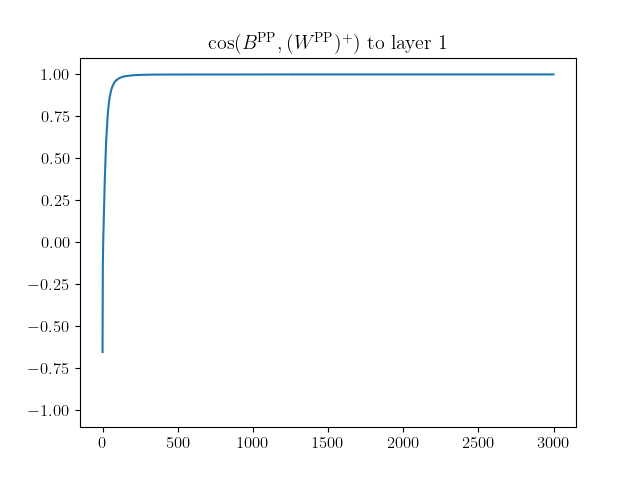

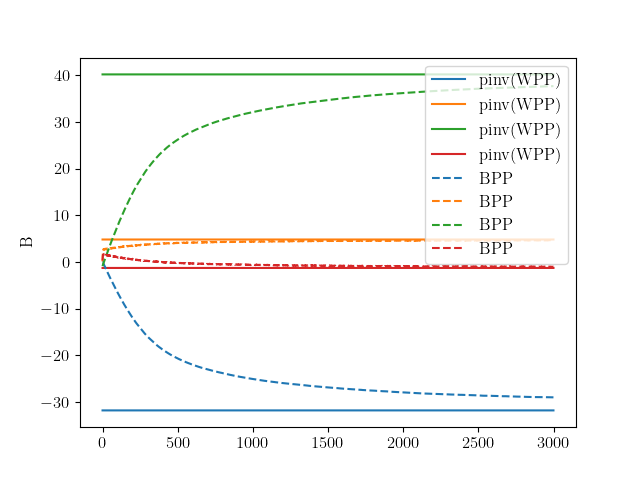

In [430]:
for i in range(len(layers[1:-1])):
    fig, ax = plt.subplots()
    ax.plot(mc1.cos_WPPpinv_BPP[i])
    plt.yscale('linear')
    # label = '10 dt'
    # plt.xlabel(label)
    plt.title('$\cos(B^\mathrm{PP}, (W^\mathrm{PP})^+)$ to layer ' + str(i+1))
    plt.ylim(-1.1,1.1)
    plt.show()
    
    
    fig, ax = plt.subplots()
    ax.plot([(gl+gbas+gapi)/gapi * np.linalg.pinv(mc1.WPP[i+1]).ravel() for BPP in mc1.BPP_time_series], label="pinv(WPP)")
    plt.gca().set_prop_cycle(None)
    ax.plot([BPP[i].ravel() for BPP in mc1.BPP_time_series], label="BPP", ls="--")
    plt.yscale('linear')
    # label = 'dt'
    # plt.xlabel(label)
    plt.ylabel("B")
    plt.legend()
    # plt.title('$\cos(W^\mathrm{IP}, W^\mathrm{PP})$ to layer ' + str(i+1))
    plt.show()

We also check if the self-predicting state has been learnt correctly:

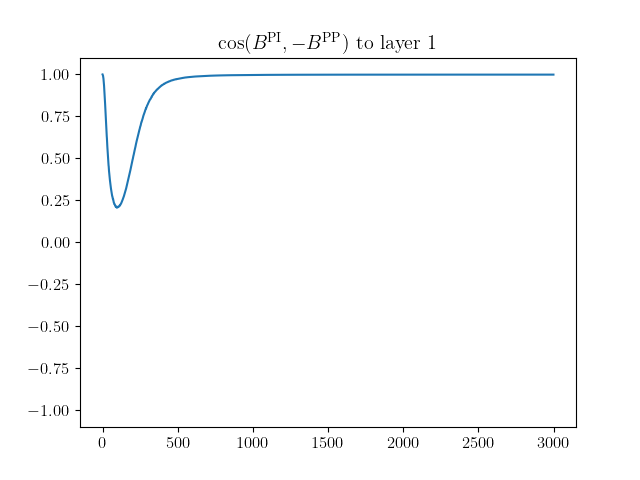

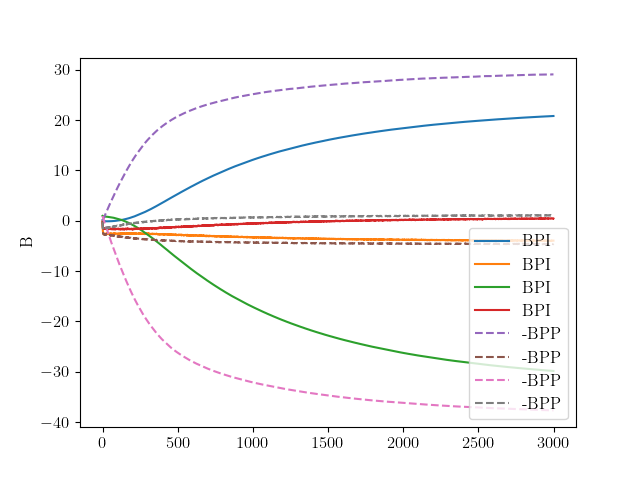

In [431]:
for i in range(len(layers[1:-1])):
    fig, ax = plt.subplots()
    ax.plot(mc1.cos_BPI_BPP[i])
    plt.yscale('linear')
    # label = '10 dt'
    # plt.xlabel(label)
    plt.title('$\cos(B^\mathrm{PI}, -B^\mathrm{PP})$ to layer ' + str(i+1))
    plt.ylim(-1.1,1.1)
    plt.show()
    
    fig, ax = plt.subplots()
    ax.plot([BPI[i].ravel() for BPI in mc1.BPI_time_series], label="BPI")
    ax.plot([-BPP[i].ravel() for BPP in mc1.BPP_time_series], label="-BPP", ls='--')
    plt.yscale('linear')
    # label = 'dt'
    # plt.xlabel(label)
    plt.ylabel("B")
    plt.legend()
    # plt.title('$\cos(W^\mathrm{IP}, W^\mathrm{PP})$ to layer ' + str(i+1))
    plt.show()

In [432]:
# for i in range(len(layers[1:-1])):
#     fig, ax = plt.subplots()
#     ax.plot(mc1.cos_WIP_WPP[i])
#     plt.yscale('linear')
#     label = '10 dt'
#     plt.xlabel(label)
#     plt.title('$\cos(W^\mathrm{IP}, W^\mathrm{PP})$ to layer ' + str(i+1))
#     plt.ylim(-1.1,1.1)
#     plt.show()


# fig, ax = plt.subplots()
# ax.plot(np.array([WPP[1] for WPP in WPP_time_series]).ravel())
# ax.plot(np.array(WIP_time_series).ravel())
# plt.yscale('linear')
# label = 'dt'
# # plt.legend()
# plt.xlabel(label)
# plt.show()